In [2]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_logistic_ci, eff_ppi_logistic_ci
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.special import expit
from baseline_utils import *
from tqdm import tqdm

In [3]:
alpha = 0.1
n = 1000
N = 10000
ds = np.array([1, 2, 3, 4])
grid_sizes = np.array([100, 1000, 5000])
num_trials = 100
eff_includeds = np.zeros((num_trials, ds.shape[0], grid_sizes.shape[0]))
eff_sizes = np.zeros((num_trials, ds.shape[0], grid_sizes.shape[0]))
includeds = np.zeros((num_trials, ds.shape[0], grid_sizes.shape[0]))
sizes = np.zeros((num_trials, ds.shape[0], grid_sizes.shape[0]))
for gs in range(grid_sizes.shape[0]):
    for j in range(ds.shape[0]):
        d = ds[j]
        for i in tqdm(range(num_trials)):
            # Make a synthetic regression problem
            X = np.random.randn(n, d)
            beta = 5*np.random.randn(d)
            beta_prediction = beta + np.random.randn(d) + 2
            Y = np.random.binomial(1, expit(X.dot(beta)))
            Yhat = expit(X.dot(beta_prediction))
            # Make a synthetic unlabeled data set with predictions Yhat
            X_unlabeled = np.random.randn(N, d)
            Yhat_unlabeled = expit(X_unlabeled.dot(beta_prediction))
            # Compute the confidence interval
            eff_ppi_ci = eff_ppi_logistic_ci(
                X, Y, Yhat, X_unlabeled, Yhat_unlabeled, alpha=alpha, grad_tol=1e-1
            )
            ppi_ci = ppi_logistic_ci(
                X, Y, Yhat, X_unlabeled, Yhat_unlabeled, alpha=alpha, grad_tol=1e-1, grid_size=20, grid_limit=grid_sizes[gs], max_refinements=3,
            )
            eff_sizes[i,j,gs] = np.array([ eff_ppi_ci[1][_d] - eff_ppi_ci[0][_d] for _d in range(d) ]).sum()
            sizes[i,j,gs] = np.array([ ppi_ci[1][_d] - ppi_ci[0][_d] for _d in range(d) ]).sum()
            # Check that the confidence interval contains the true beta
            eff_includeds[i,j,gs] = int(
                (eff_ppi_ci[0][0] <= beta[0]) & (beta[0] <= eff_ppi_ci[1][0])
            )
            includeds[i,j,gs] = int(
                (ppi_ci[0][0] <= beta[0]) & (beta[0] <= ppi_ci[1][0])
            )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:16<00:00,  2.57s/it]


[ 1.02564103  7.55555556 13.33333333         inf] 2 13.333333333333332
[ 0.82051282 22.4                inf 32.        ] 1 22.4
[ 0.87179487 12.23529412         inf         inf] 1 12.235294117647058


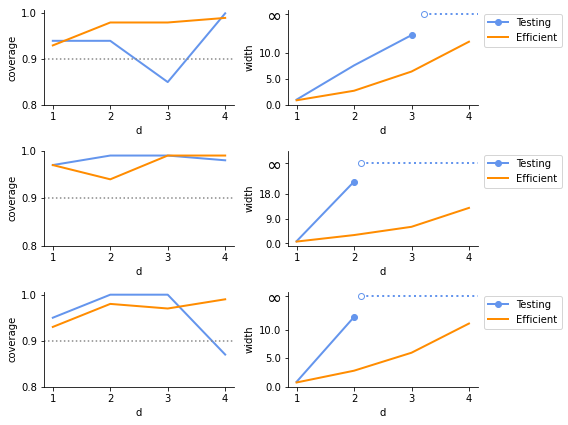

In [81]:
eff_color = 'darkorange'
test_color = 'cornflowerblue'
linewidth=2

fig, axs = plt.subplots(nrows=grid_sizes.shape[0], ncols=2, figsize=(8,2*grid_sizes.shape[0]))
for gs in range(grid_sizes.shape[0]):
    cvg_ax = axs[gs, 0]
    sz_ax = axs[gs, 1]
    cvg_ax.plot(ds, includeds[:,:,gs].mean(axis=0), color=test_color, linewidth=linewidth, label='Testing')
    cvg_ax.plot(ds, eff_includeds[:,:,gs].mean(axis=0), color=eff_color, linewidth=linewidth, label='Efficient')
    cvg_ax.axhline(y=1-alpha, linestyle='dotted', color='#888888')
    cvg_ax.set_yticks([0.8, 0.9, 1])
    median_sizes = np.median(sizes[:,:,gs], axis=0)
    median_eff_sizes = np.median(eff_sizes[:,:,gs], axis=0)
    if np.any(np.isinf(median_sizes)):
        largest_finite_index_sizes = np.where(np.isinf(median_sizes))[0][0]-1
    else:
        largest_finite_index_sizes = -1
    if np.any(np.isinf(median_eff_sizes)):
        largest_finite_index_eff_sizes = np.where(np.isinf(median_eff_sizes))[0][0]-1
    else:
        largest_finite_index_eff_sizes = -1
    max_y = max(median_sizes[largest_finite_index_sizes], median_eff_sizes[largest_finite_index_eff_sizes])
    inf_line_y = 1.3 * max_y
    if np.any(np.isinf(median_sizes)):
        sz_line = sz_ax.plot(ds, median_sizes, color=test_color, linewidth=linewidth, markevery=[np.where(np.isinf(median_sizes))[0][0]-1], marker='o', label='Testing')
        first_inf = np.where(np.isinf(median_sizes))[0][0]
        first_inf_ax_coord = (first_inf - ds.min())/(ds.max() - ds.min()) + 0.05
        sz_ax.axhline(y=inf_line_y, xmin=first_inf_ax_coord, linewidth=linewidth, color=sz_line[0].get_color(), markevery=[0], marker='o', markerfacecolor='white', linestyle='dotted')
    else:
        sz_line = sz_ax.plot(ds, median_sizes, color=test_color, linewidth=linewidth, label='Testing')

    sz_ax.plot(ds, median_eff_sizes, color=eff_color, linewidth=linewidth, label='Efficient')
    sz_ax.set_yticks([0.0, inf_line_y//3, 2*(inf_line_y//3)])

    # Update yticks to include infinity symbol
    current_yticks = sz_ax.get_yticks()
    sz_ax.set_yticks(list(current_yticks) + [inf_line_y], list(map(str, current_yticks)) + ["$\infty$"])
    # Modify the properties of the tick label at y = \infty
    for label in sz_ax.get_yticklabels():
        if label.get_text() == "$\infty$":  # or any other condition that identifies the desired tick label
            label.set_fontsize(18)  # or any desired size
            
    cvg_ax.set_xlabel('d')
    cvg_ax.set_ylabel('coverage')
    sz_ax.legend(bbox_to_anchor=(1.01, 1.01))
    sz_ax.set_ylabel('width')
    sz_ax.set_xlabel('d')
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.savefig('./plots/eff-comparison.pdf')

In [56]:
coord = 0
print(np.median(sizes[:,:,coord],axis=1))
print(includeds[:,:,coord].mean(axis=0))
print()
print(sizes[:,:,coord])

[10.66666667  5.71428571  8.95238095  9.33333333         inf 23.11111111
  9.55555556         inf  4.95238095  8.22222222 10.         26.
  7.11111111 15.9047619          inf         inf         inf 31.11111111
 11.11111111  8.44444444 17.71428571 14.4                inf         inf
         inf         inf  6.66666667         inf  8.                 inf
 25.14285714 25.71428571         inf  8.6835443          inf 16.88888889
         inf         inf 18.4                inf  5.61904762         inf
         inf  8.44444444         inf 19.11111111 10.                 inf
 12.44444444  6.66666667 11.44444444 10.66666667 25.71428571 13.71428571
 30.4        18.         30.4         9.55555556  7.9047619          inf
         inf 16.44444444  7.71428571 19.55555556 26.          5.51054852
  8.                 inf  7.11111111         inf         inf         inf
 33.77777778         inf  8.88888889         inf         inf         inf
 13.06666667 13.33333333         inf         inf  5.0476190